#  <font color=#F03415> Capacitated Fixed Charge Facility Location Problem (CFCFLP) | Optimización | Relajación Lagrangiana </font> 


## <font color=#F03415> Formulación Matemática del Problema </font> 

####  <font color=#F03415> Conjuntos </font> 

- Clientes ($I$): Conjunto de **clientes** 
- Plantas ($J$): Conjunto de **plantas candidatas** 

####  <font color=#F03415> Parámetros </font> 

- $f_{j}$ = Costo fijo de abrir una planta $j$ 

- $k_j$ = Capacidad máxima de cada instalación $j$ 

- $d_{ij}$ = Distancia recorrida en kilómetros para atender al cliente $i$ a través de la planta $j$

- $h_{i}$ = Demanda del cliente cliente $i$   

- $\alpha$ = Costo de transporte por unidad y kilómetros de distancia.

####  <font color=#F03415> Variables de decisión </font> 

- $y_{ij}$ = **1** si se el cliente $i$ es asignado a la planta $j$. **0** de otra manera.

- $x_{j}$ = **1** si se abre la planta $j$. **0** de otra manera.


####  <font color=#F03415> Función Objetivo y Restricciones </font> 

\begin{align}
Min && \sum_{j\in J} f_j*x_j + \alpha *\sum_{i\in I}\sum_{j\in J}(h_i*d_{ij}*y_{ij}) && && \\
s.a && \sum_{j\in J} y_{ij} = 1 && \forall i\in I &&(1)\\
&& y_{ij} \leq x_j && \forall i\in I \ \forall j\in J &&(2) \\
&& \sum_{i\in I} h_i*y_{ij} \leq k_j*x_j && \forall j\in J \ &&(3) \\
&& y_{ij} \in \{0,1\} && \forall i\in I \ \forall j\in J &&(4)\\
&& x_j \in \{0,1\} && \forall i\in I &&(5)\\
\end{align}

La función objetivo busca minimizar la suma de los costos fijos ($f_j$) de localizar las plantas $j$ y la distancia recorrida ($d_{ij}$) ponderada por la demanda ($h_i$) de los clientes $i$, $\forall i\in I \, \forall j\in J$, asociado a un costo de transporte por unidad y kilómetros de distancia recorridos ($\alpha$). 

La primera restricción se encarga de asegurar la asignación única de cada cliente $i$, (2) permite la asignación a una planta $j$ solo si esta está abierta. La restricción (3) establece que cada planta $j$ localizada puede almacenar hasta $k_j$ unidades. Las restricciones (4) y (5) modelan la integralidad de las variables de decisión.

#  <font color=#F03415> Derivación computacional de la solución óptima </font> 

##  <font color=#F03415> Importar Librerías </font> 

In [1]:
#Librerías para realizar cálculos
import time
import numpy as np
import pandas as pd

#Librerías para los gráficos
import folium 
from folium import features
from geopy import distance 
import matplotlib.pyplot as plt

#Optimización con Gurobi
from gurobipy import Model, GRB, quicksum

##  <font color=#F03415> Creación de parámetros </font> 

In [2]:
#Lista para guardar resultados
resultados=[] 
resultados2=[] 

In [3]:
#Semilla fija
np.random.seed(100)

#Conjuntos
cant_p=20   #plantas
cant_c=20   #clientes
plantas=[i for i in range(cant_p)]
clientes=[j for j in range(cant_c)]

#Latitud y Longitud condicionados a la ciudad de La Serena,Chile.
x_plantas=list(np.random.random(cant_p)*(-29.979466--28.950729)-29.950729)
x_clientes=list(np.random.random(cant_c)*(-29.979466--28.950729)-29.950729)
y_plantas=list(np.random.random(cant_p)*(-71.305824--70.255720)-70.255720)
y_clientes=list(np.random.random(cant_c)*(-71.305824--70.215720)-70.215720)

#Parámetros
h=list(np.random.randint(10,50,cant_c)) #demanda de los clientes i
k=list(np.random.randint(50,100,cant_p)) #capacidad de las plantas j
#Nota: La demanda varía entre 200 (10*20) y 1000 (50*20) por los 20 clientes, por lo que, se asigna una capacidad 
      #arbitraria por planta que varia entre 50 y 100 cada una.
f=list(np.random.randint(2000,3000,cant_p)) #costo fijo de abrir una planta
alfa=0.1   #costo unitario por km
#Distancia recorrida en kilómetros para atender al cliente 𝑖 a través de la planta 𝑗
d={(i,j):distance.distance((x_plantas[i],y_plantas[i]),(x_clientes[j],y_clientes[j])).km for i in plantas for j in clientes}

arcos=[(i,j) for i in clientes for j in plantas]

##  <font color=#F03415> Gráfico de situación actual  </font> 

In [4]:
mapa = folium.Map(location=[(-31.979466-28.950729)/2,(-71.305824-70.255720)/2],zoom_start=9)


fg=folium.FeatureGroup()  
for j in plantas: 
    fg.add_child(folium.CircleMarker(location=[x_plantas[j],y_plantas[j]],radius=5,
                                     color='green',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[x_plantas[j],y_plantas[j]],
                           popup=folium.Popup(str(x_plantas[j])+str(y_plantas[j])),
                           icon=folium.Icon(color='green',
                                            icon_color='white',icon='home')))
for i in clientes: 
    fg.add_child(folium.CircleMarker(location=[x_clientes[i],y_clientes[i]],radius=3,
                                     color='blue',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[x_clientes[i],y_clientes[i]],
                           popup=folium.Popup(str(x_clientes[i])+str(y_clientes[i])),
                           icon=folium.Icon(color='blue',
                                            icon_color='white',icon='info-sign')))
    
mapa.add_child(fg)
mapa

##  <font color=#F03415> Modelo matemático con Python y Gurobi </font> 

In [5]:
inicio_Original = time.time() #Sirve para calcular el tiempo de ejecución del modelo
mdl=Model('CFCFLP')

Academic license - for non-commercial use only - expires 2022-01-09
Using license file C:\Users\bryan\gurobi.lic


In [6]:
#Variables de decisión
x=mdl.addVars(plantas,vtype=GRB.BINARY,name='x') 
y=mdl.addVars(clientes,plantas,vtype=GRB.BINARY,name='y')

#Función Objetivo
obj=quicksum(f[j]*x[j] for j in plantas)+ alfa*quicksum(h[i]*d[i,j]*y[i,j] for i in clientes for j in plantas)
mdl.setObjective(obj, GRB.MINIMIZE)

#Restricciones 
mdl.addConstrs(quicksum(y[i, j] for j in plantas) == 1 for i in clientes) #(1)
mdl.addConstrs(y[i,j] <= x[j] for i in clientes for j in plantas) #(2)
mdl.addConstrs(quicksum(h[i]*y[i, j] for i in clientes) <= k[j]*x[j] for j in plantas) #(3)

#Optimización
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 420 columns and 1620 nonzeros
Model fingerprint: 0xaaeb354c
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [8e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 41083.256150
Presolve removed 144 rows and 0 columns
Presolve time: 0.03s
Presolved: 296 rows, 420 columns, 1989 nonzeros
Variable types: 0 continuous, 420 integer (420 binary)

Root relaxation: objective 1.862762e+04, 153 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18627.6187    0   27 41083.2562 18627.6187  54.7%     -    0s
H    0     0                    23030.146987 18627.

In [7]:
final_original = time.time() - inicio_Original
print("Tiempo de ejecución del modelo CFCFLP",round(final_original,2), "segundos")

Tiempo de ejecución del modelo CFCFLP 1.52 segundos


In [8]:
#Estado de la solución
valor_óptimo=[] #lista para graficar soluciones
FO_óptimo=round(mdl.objVal,6) #almacena la F.O para el dataframe del análisis
if mdl.status==2:
    print("El costo total del sistema es de $",str(round(mdl.objVal,2)))
    valor_óptimo.append(round(mdl.objVal,2))
    print()
else:
    print("Solución Infactible")

El costo total del sistema es de $ 19593.54



In [9]:
arcos_activos=[k for k in arcos if y[k].x> 0.99] 

for j in plantas:
    if x[j].x>0.9:
        demandas_clientes=0
        print("La planta",j+1, "con una capacidad de",k[j],"productos")
        for i in clientes:
            if y[i,j].x>0.9:
                print("   abastece al cliente",i+1, "con una demanda de",h[i])
                demandas_clientes+=h[i]
        utilización=round((demandas_clientes/k[j])*100,2)
        print("")
        print("   Utilizando el ",utilización,"% de su capacidad")
        print("")             
        demandas_clientes=0       

La planta 1 con una capacidad de 62 productos
   abastece al cliente 3 con una demanda de 34
   abastece al cliente 8 con una demanda de 26

   Utilizando el  96.77 % de su capacidad

La planta 3 con una capacidad de 79 productos
   abastece al cliente 7 con una demanda de 45
   abastece al cliente 11 con una demanda de 28

   Utilizando el  92.41 % de su capacidad

La planta 4 con una capacidad de 78 productos
   abastece al cliente 18 con una demanda de 35
   abastece al cliente 20 con una demanda de 40

   Utilizando el  96.15 % de su capacidad

La planta 5 con una capacidad de 94 productos
   abastece al cliente 6 con una demanda de 35
   abastece al cliente 14 con una demanda de 41
   abastece al cliente 17 con una demanda de 18

   Utilizando el  100.0 % de su capacidad

La planta 8 con una capacidad de 90 productos
   abastece al cliente 9 con una demanda de 22
   abastece al cliente 13 con una demanda de 38
   abastece al cliente 15 con una demanda de 30

   Utilizando el  100.

In [10]:
#incorporar datos a la lista para el dataframe.
resultados.append(['Óptimo',FO_óptimo,final_original,'0.0%']) 
resultados2.append(['Óptimo',FO_óptimo,'0.0%']) 

##  <font color=#F03415> Gráfico de solución óptima  </font> 

In [11]:
color_plot ={0:'#A9A9A9',1:'#708090',2:'#BC8F8F ',3:'#32CD32',4:'#603cba',5:'#e3a21a',
             6:'#9f00a7',7:'#da532c',8:'#ff0097',9:'#e3a21a',10:'#2d89ef',11:'#2E8B57',
             12:'#da532c',13:'#708090',14:'#eff4ff',15:'#d11141',16:'#DC143C',17:'#A52A2A',
            18:'#FFA500',19:'#FFDAB9',20:'#F0E68C',21:'#ffc40d',22:'#E6E6FA',23:'#E6E6FA',
            24:'#DA70D6',25:'#8A2BE2',26:'#8B008B',27:'#7CFC00',28:'#FFE4E1',29:'#2E8B57',
            30:'#808000',31:'#66CDAA',32:'#008080',33:'#191970',34:'#2b5797',35:'#b91d47',
            36:'#2d89ef',37:'#99b433',38:'#ffc40d',39:'#FFD700',40:'#000000'}

mapa = folium.Map(location=[(-31.979466-28.950729)/2,(-71.305824-70.255720)/2],zoom_start=9)

fg=folium.FeatureGroup()  

for j in plantas: 
    if x[j].x>0.9:
        color_planta='green'
    else:
        color_planta='darkgreen'   
    
    fg.add_child(folium.CircleMarker(location=[x_plantas[j],y_plantas[j]],radius=5,
                                     color='green',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[x_plantas[j],y_plantas[j]],
                           popup=folium.Popup(str(x_plantas[j])+str(y_plantas[j])),
                           icon=folium.Icon(color=color_planta,
                                            icon_color='white',icon='home')))
for i in clientes: 
    fg.add_child(folium.CircleMarker(location=[x_clientes[i],y_clientes[i]],radius=3,
                                     color='blue',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[x_clientes[i],y_clientes[i]],
                           popup=folium.Popup(str(x_clientes[i])+str(y_clientes[i])),
                           icon=folium.Icon(color='blue',
                                            icon_color='white',icon='info-sign')))
for i,j in arcos_activos:  
    my_PolyLine = folium.PolyLine([(x_clientes[i],y_clientes[i]),
                                  (x_plantas[j],y_plantas[j])], 
                                  color=color_plot[j], weight=2.5, opacity=1).add_to(mapa)                                
    mapa.add_child(my_PolyLine)
    
mapa.add_child(fg)
mapa

#  <font color=#F03415> Relajación Lagrangiana de la restricción 1 </font> 

##  <font color=#F03415> Lower Bound | Subproblema 1</font> 

Se relaja la primera restricción del modelo base, la cual se señala a continuación:

\begin{align}
&& \sum_{j\in J} y_{ij} = 1 && \forall i\in I &&(1) \\
\
\end{align}

(1) se quita de las restricciones del modelo base y se sube a la función objetivo ponderada por el multiplicador de Lagrange, en este caso $\lambda_i$, debido a que se necesita por cada una de las restricciones relajadas de $I$ (viene del ${i\;\in\;I}$ de la restricción). Además, el término  $\displaystyle (1-\sum_{j\;\in\;J} y_{ij}) \;\;\; $ se calcula debido a que se está minimizando la función objetivo. Por lo tanto, la relajación lagrangiana del modelo base se resolverá mediante la siguiente formulación matemática:

\begin{align}
Min && \sum_{j\in J} f_j*x_j + \alpha *\sum_{i\in I}\sum_{j\in J}(h_i*d_{ij}*y_{ij})+ \sum_{i\in I} \lambda_{i}(1-\sum_{j\in J} y_{ij}) && &&\\
s.a && y_{ij} \leq x_j && \forall i\in I \ \forall j\in J && \\
&& \sum_{i\in I} h_i*y_{ij} \leq k_j*x_j && \forall j\in J \ && \\
&& y_{ij} \in \{0,1\} && \forall i\in I \ \forall j\in J &&\\
&& x_j \in \{0,1\} && \forall i\in I &&\\
\end{align}

##  <font color=#F03415> Upper Bound | Subproblema 2</font> 

De la solución obtenida anteriormente en la relajación de la restricción 1 (lower bound), es posible encontrar una cota superior (upper bound) del problema original. Para ello, se fija los valores de la variable de primera etapa ($x$). Por lo tanto, será posible resolver el problema de transporte resultante, manteniendo todas las restricciones originales del CFCFLP. 

**Notas:** 

- De la solución óptima del problema relajado (Lower Bound) se obtiene la variable $x_j$ la cual será parametrizada como $X_j$ como una lista con valores enteros.

- Al transformar en parámetro la variable x, el primer término de la función objetivo podría eliminarse ya que son constantes, sin embargo, se mantiene por efectos prácticos en el valor de la solución final.

En base a lo antes mencionado, se plantea el siguiente problema de transporte:

\begin{align}
Min && \sum_{j\in J} f_j*X_j + \alpha *\sum_{i\in I}\sum_{j\in J}(h_i*d_{ij}*y_{ij}) && &&\\
s.a && \sum_{j\in J} y_{ij} = 1 && \forall i\in I &&\\
&& y_{ij} \leq X_j && \forall i\in I \ \forall j\in J && \\
&& \sum_{i\in I} h_i*y_{ij} \leq k_j*X_j && \forall j\in J \ && \\
&& y_{ij} \in \{0,1\} && \forall i\in I \ \forall j\in J &&\\
\end{align}

##  <font color=#F03415> Cotas iniciales | Ineficientes | Pág. 260-270 Daskin (1995) </font> 

In [12]:
#Cota inferior factible pero ineficiente, según Daskin (páginas 263-264).
Z_LB=0 

#Cota superior
dist_maximas=[] #distancias máxima de las plantas por cada cliente.
for i in clientes:
    dist_maxima=max(h[i]*d[i,j] for j in plantas)
    dist_maximas.append(dist_maxima)  
sumas_dist=sum(dist_maximas)
   
Z_UB= sum(f[j] for j in plantas) +alfa * sumas_dist
#Según Daskin (pág 263-264) el UB será igual a localizar todas las instalaciones (suma de fj) y asignar a las mayores distancias
#Localiza todas las plantas y se le asocia el cliente más lejano. No puede tener solución peor.

In [13]:
#Almacenar valores en la lista resultados2 para usarlos en el dataframe
GAP_LB_inicial=round(((FO_óptimo-Z_LB)/FO_óptimo)*100,3)
gap_lb_inicial=(str(GAP_LB_inicial)+'%')

GAP_UB_inicial=round(((Z_UB-FO_óptimo)/FO_óptimo)*100,3)
gap_ub_inicial=(str(GAP_UB_inicial)+'%')

resultados2.append(['LB ineficientes iniciales',Z_LB,gap_lb_inicial])
resultados2.append(['UB ineficientes iniciales',Z_UB,gap_ub_inicial])

##  <font color=#F03415> Resolución de los subproblemas con Python y Gurobi </font> 

In [14]:
#Parametrizar valores para resolución

lamb=[0 for _ in range (cant_c)] #inicialmente ceros por cada cliente i

holgura={} #Holguras asociadas a la relajaciones de las restricciones subidas a la función objetivo
escala=2 #se recomienda que sea menor o igual a dos según Daskin (1995)
eps= 1e-2 #epsilón para detener las iteraciones

cont_iter=0 #contador de iteraciones en las que la cota inferior no han cambiado
lim_iter=5 #límite del contador de iteraciones

max_iter=300 #máx cantidad de iteraciones

LB=[]
UB=[]
LB.append(Z_LB)
UB.append(Z_UB)

GAP=[1.0] #lista para agregar los gap de las optimalidades.
inicio_LB = time.time() #tiempo de ejecución

óptimo=[valor_óptimo] #lista para gráfico

for q in range(max_iter):
    #Modelo Lower Bound | subproblema 1
    mdlLB=Model('LB-LR')
    
    #Variables de decisión
    xLB=mdlLB.addVars(plantas,vtype=GRB.BINARY,name='xLB') 
    yLB=mdlLB.addVars(clientes,plantas,vtype=GRB.BINARY,name='yLB')

    #Función Objetivo del problema relajado
    obj=quicksum(f[j]*xLB[j] for j in plantas) + alfa*quicksum(h[i]*d[i,j]*yLB[i,j] for i in clientes for j in plantas)
    rel=quicksum(lamb[i]*(1-quicksum(yLB[i,j] for j in plantas)) for i in clientes)
    
    mdlLB.setObjective(obj+rel, GRB.MINIMIZE)

    #Restricciones  
    mdlLB.addConstrs(yLB[i,j] <= xLB[j] for i in clientes for j in plantas)
    mdlLB.addConstrs(quicksum(h[i]*yLB[i, j] for i in clientes) <= k[j]*xLB[j] for j in plantas)

    #Optimización LB
    mdlLB.optimize()
      
    #Solución de la optimización (F.O) y variables de decisión del subproblema 1
    sol_var_y=np.zeros((cant_c,cant_p))   
    sol_var_x=[0 for _ in range (cant_c)]
    for j in plantas:
        if xLB[j].x==1:
            sol_var_x[j]=1        
        for i in clientes:                
            if yLB[i,j].x==1:
                sol_var_y[i,j]=1
                
    X=sol_var_x
    Y_D=sol_var_y    
    Z_D=mdlLB.objVal #solución óptima del problema relajado (cota inferior)

    #Actualización de holguras
    for i in clientes:
        holgura[i] = 1 - sum(Y_D[i,j] for j in plantas)    
        # Si todas las holguras fueran cero (1-1(restricción)), estaríamos en el óptimo del problema original.  
    
    #Actualizar cota inferior (LB)
    if Z_D > Z_LB:
        #Si es que el dual lagrangiano es mayor se actualiza la cota inferior
        Z_LB=Z_D
        cont_iter=0
    else: 
        cont_iter+=1
        
    if cont_iter==lim_iter:
        escala=escala/2 #reducir los pasos (step)
        cont_iter=0
    
    #Actualizar los pasos (step)
    norm = sum(holgura[i]**2 for i in clientes) #Página 263 Daskin, norma 2 de las holguras. 
    step = escala * (Z_UB - Z_D)/norm  #Fórmula para actualizar
    
    #Calcular los nuevos lambda    
    for i in clientes:
        lamb[i] = lamb[i] + step * holgura[i]
          
    #Actualizar la cota superior (Upper Bound) | Resolver problema de transporte dado un X fijo de la sol lagrangiana.
    if sum(k[j]*X[j] for j in plantas)>= sum(h[i] for i in clientes):
        #Dado X fijo, si es que este cumple con la factibilidad base, entonces se resuelve UB
        #Para ello, se debe cumplir que la capacidad de todas las plantas debe superar a la demanda de los clientes.

        #Modelo Upper Bound | subproblema 2
        mdlUB=Model('UB-LR')
        
        #Variables de decisión (se elimina la variable x)
        yUB=mdlUB.addVars(clientes,plantas,vtype=GRB.BINARY,name='yUB')

        #Función Objetivo (se elimina la relajación de los lambda & x es una lista con parámetros (X))
        obj=quicksum(f[j]*X[j] for j in plantas) + alfa*quicksum(h[i]*d[i,j]*yUB[i,j] for i in clientes for j in plantas)
        mdlUB.setObjective(obj, GRB.MINIMIZE)

        #Restricciones del modelo original utilizando los valores del parámetro X
        mdlUB.addConstrs(quicksum(yUB[i, j] for j in plantas) == 1 for i in clientes)
        mdlUB.addConstrs(yUB[i,j] <= X[j] for i in clientes for j in plantas)
        mdlUB.addConstrs(quicksum(h[i]*yUB[i, j] for i in clientes) <= k[j]*X[j] for j in plantas)

        #Optimización UB
        mdlUB.optimize()
        
        #Solución de la optimización (F.O) y variables de decisión del subproblema 2
        sol_var_yUB=np.zeros((cant_c,cant_p))   
        for j in plantas:      
            for i in clientes:                
                if yUB[i,j].x==1:
                    sol_var_y[i,j]=1
                    
        Y=sol_var_yUB
        Z=mdlUB.objVal      
        
        #Nuevo valor del limite superior
        Z_UB=min(Z_UB,Z)
        
    #Completar lista con las cotas
    LB.append(Z_LB)
    UB.append(Z_UB)
    
    #Lista con valor óptimo según las iteraciones. Se usa para graficar
    óptimo.append(valor_óptimo)
        
    #Calcular el gap de optimalidad        
    duality_gap=(Z_UB - Z_LB) / Z_UB
    GAP.append(duality_gap)
    
    #Criterios de detención    
    if duality_gap < eps:   
        break
    
    if step < 1e-8:  #Si el paso es muy pequeño se termina
        break
        
    #Imprimir Resultados    
    print("\n---------------------------------------------------")
    print("Iteración: ",q+1)
    print("Paso: ",step)
    print("LB: ",Z_LB)
    print("UB: ",Z_UB)
    print("Multiplicadores de Lagrange: ",lamb)
    print("GAP de optimalidad: ",duality_gap)
    print("\n---------------------------------------------------")
        
final_LB = time.time() - inicio_LB

#obtener valores para el dataframe
LB_ineficiente=max(LB)
UB_ineficiente=min(UB)

GAP_LB=round(((FO_óptimo-LB_ineficiente)/FO_óptimo)*100,3)
gap_lb=(str(GAP_LB)+'%')

GAP_UB=round(((UB_ineficiente-FO_óptimo)/FO_óptimo)*100,3)
gap_ub=(str(GAP_UB)+'%')

#Copiar valores para graficar las soluciones en el análisis
LB2=LB
UB2=UB
GAP2=GAP
óptimo2=óptimo

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x5cffb0ad
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [8e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

---------------------------------------------------
Iteración:  1
Paso:  5550.011942663214
LB:  0
UB:  55500.11942663213
Multiplicadores de Lagrange:  [5550.011942663214, 5550.011942663214, 5550.011942663214, 5550.011942663214, 5550.011942663214, 5550.011942663214, 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xa63a3ebd
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [5e+02, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 46586.610384
Presolve removed 419 rows and 406 columns
Presolve time: 0.02s
Presolved: 1 rows, 14 columns, 14 nonzeros
Found heuristic solution: objective -130179.1838
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective -1.348340e+05, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -134834.03    0    1 -130179.18 -134834.03  3.58%     -    0s
H    0  

Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 52825.256150
Presolve removed 400 rows and 0 columns
Presolve time: 0.01s
Presolved: 40 rows, 400 columns, 800 nonzeros
Variable types: 0 continuous, 400 integer (400 binary)

Root relaxation: objective 5.020444e+04, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 50204.4442    0    4 52825.2562 50204.4442  4.96%     -    0s
H    0     0                    50279.873809 50204.4442  0.15%     -    0s
H    0     0                    50239.154863 50204.4442  0.07%     -    0s

Cutting planes:
  Cover: 1
  MIR: 1
  RLT: 1

Explored 1 nodes (24 simplex iterations) in 0.07 seconds
Thread count was 8 (of 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x2a430d6c
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -17504.58323
Presolve removed 413 rows and 413 columns
Presolve time: 0.02s
Presolved: 7 rows, 7 columns, 19 nonzeros
Found heuristic solution: objective -22358.80596
Variable types: 0 continuous, 7 integer (7 binary)

Root relaxation: objective -2.256219e+04, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      -22358.806 -22358.806  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.05 seconds
Thread co

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x3d3d62c1
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 1592.1083702
Presolve removed 407 rows and 407 columns
Presolve time: 0.04s
Presolved: 13 rows, 13 columns, 37 nonzeros
Found heuristic solution: objective -11468.50617
Variable types: 0 continuous, 13 integer (13 binary)

Root relaxation: objective -1.340961e+04, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -13409.610    0    1 -11468.506 -13409.610  16.9%     -    0s
H    0 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      -997.71104 -997.71104  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: -997.711 -718.088 
No other solutions better than -997.711

Optimal solution found (tolerance 1.00e-04)
Best objective -9.977110385061e+02, best bound -9.977110385061e+02, gap 0.0000%

---------------------------------------------------
Iteración:  14
Paso:  566.9574318507456
LB:  0
UB:  21680.586235523715
Multiplicadores de Lagrange:  [1708.0756797291006, -534.9237516911534, 1261.2705130894078, -166.02428153072185, 977.9989441738247, -7588.233566628088, 808.6402503761783, 933.1619368578536, 732.4986124721188, 1403.2844089559767, 588.7637123472318, 730.6197016867118, 289.90315640062914, 1658.0229861287198, 865.1724113891725, 1179.3123915951564, 312.08910972690734, 1529.6071519326474, 959.5991762341423, 704.39247607

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x2ef04f7c
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [8e+00, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 7372.8493386
Presolve removed 402 rows and 402 columns
Presolve time: 0.03s
Presolved: 18 rows, 18 columns, 52 nonzeros
Found heuristic solution: objective 4803.8040083
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: objective 3.629912e+03, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3629.91159    0    1 4803.80401 3629.91159  24.4%     -    0s
H    0     0                    3895.5263389 3629.91159  6.82% 

  Cover: 2
  MIR: 1
  StrongCG: 1
  RLT: 1

Explored 1 nodes (8 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 6543.28 6570.86 6576.6 ... 7268.61

Optimal solution found (tolerance 1.00e-04)
Best objective 6.543276782175e+03, best bound 6.543276782175e+03, gap 0.0000%

---------------------------------------------------
Iteración:  19
Paso:  219.32806938856314
LB:  6543.276782175344
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1485.428909473163, -77.00067405559648, 993.5631942278403, 291.898796104835, 1435.9220218093817, -7130.31048899253, 1266.5633280117352, 1017.4985462104863, 759.0702791450723, 1088.1035769332266, 827.3587205942256, 299.93050561001195, 747.826234036186, 1504.3563952070758, 946.7958713624023, 647.6801928449268, 770.0121873624641, 964.3021466691844, 679.8985637922065, 1162.3155537101788]
GAP de optimalidad:  0.6679038850922868

---------------------------------------------------
Gurobi Optimizer version 

Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      9663.49421 9663.49421  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 9663.49 11136.6 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.663494207484e+03, best bound 9.663494207484e+03, gap 0.0000%

---------------------------------------------------
Iteración:  23
Paso:  119.51746116673233
LB:  9663.494207483616
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1485.3532889480434, 351.02387458114, 944.4174419494216, 719.9233447415714, 1745.32865303116, -6702.285940355793, 1575.0704154817395, 875.8555846820854, 677.2994789877167, 897.3904836515264, 1017.2478906492714, 312.3047611559476, 117


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      11028.1430 11028.1430  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 11028.1 12675.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.102814297600e+04, best bound 1.102814297600e+04, gap 0.0000%

---------------------------------------------------
Iteración:  26
Paso:  144.58029949149747
LB:  11028.142975999284
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1471.0067273719646, 351.02387458114, 1123.505457837847, 899.0113606299968, 1554.4931181240868, -6378.617624975871, 1398.581442150745, 933.858339116309, 735.3022334219404, 1221.0587990314493, 1208.0834255563448, 358.5599965715233, 1288.522408324923, 1489.9342131058775, 855.3166428012123, 700.7812637752343, 667.5385025783789, 1265.963398

Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0xdec484ed
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 26411.660381
Presolve removed 410 rows and 200 columns
Presolve time: 0.00s
Presolved: 30 rows, 200 columns, 400 nonzeros
Variable types: 0 continuous, 200 integer (200 binary)

Root relaxation: objective 2.430879e+04, 25 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 24308.7866    0    6 26411.6604 24308.7866  7.96%     -    0s
H    0     0                    24402.980534 24308.7866  0.39%     -    0s
*    0     0               0    24371.180557 24371.1806  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Co

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7

Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x6162fdcd
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 23782.946779
Presolve removed 411 rows and 220 columns
Presolve time: 0.00s
Presolved: 29 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 2.159953e+04, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21599.5340    0   10 23782.9468 21599.5340  9.18%     -    0s
H    0     0                    21981.833758 21599.5340  1.74%     -    0s
H    0     0                    21851.485558 21599.5340  1.15%     -    0s
H    0     0                    2


Root relaxation: cutoff, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      11623.9578 11623.9578  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 11624 14327.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.162395778911e+04, best bound 1.162395778911e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x6162fdcd
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic sol

Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  39
Paso:  57.61867551179418
LB:  11866.821075885124
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1463.3121538959065, 350.5946171268846, 1049.3146376337424, 998.4200228040243, 1714.046645078896, -5427.776287408351, 1609.1574283793445, 1036.835913370628, 675.6739364170764, 1103.2672465777175, 966.2229511168497, 410.16270171680526, 1384.6178422194794, 1333.5828541494627, 962.0913238828266, 659.7943734015746, 675.078925931728, 1185.4722952752784, 630.0840881337731, 1469.261177062014]
GAP de optimalidad:  0.397713820338158

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 th


Optimal solution found (tolerance 1.00e-04)
Best objective 1.233790472109e+04, best bound 1.233790472109e+04, gap 0.0000%

---------------------------------------------------
Iteración:  42
Paso:  65.75943057495978
LB:  12337.904721093637
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1402.4242988831334, 426.1343595335791, 1266.1907137294522, 973.9506628710069, 1689.577285145879, -5210.900211312641, 1584.6880684463274, 910.1886277828953, 746.3421032615842, 1169.0266771526774, 1051.5801660626398, 288.42415239862044, 1299.2606272736894, 1353.180638520293, 1018.0704426260517, 598.9436790961628, 670.1701896621801, 1124.6216009698664, 639.8643999655077, 1408.3733220492409]
GAP de optimalidad:  0.373804538554987

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xb1978a6c

Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0        

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xa9bea870
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 14567.192933
Presolve removed 409 rows and 404 columns
Presolve time: 0.04s
Presolved: 11 rows, 16 columns, 64 nonzeros
Found heuristic solution: objective 12648.189016
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      12648.1890 12648.1890  0.00%     -    0s

Explored 0 nodes (5 sim

     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  50
Paso:  52.747660568426525
LB:  12740.269750456831
UB

Presolve removed 407 rows and 403 columns
Presolve time: 0.06s
Presolved: 13 rows, 17 columns, 64 nonzeros
Found heuristic solution: objective 12913.455294
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      12913.4553 12913.4553  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 12913.5 15043.5 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.291345529420e+04, best bound 1.291345529420e+04, gap 0.0000%

---------------------------------------------------
Iteración:  53
Paso:  94.29868960121199
LB:  12913.455294201869
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1387.984059638492, 112.08937029877518, 1171.3554432214935, 976.1645126481492

Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x6162fdcd
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 23782.946779
Presolve removed 411 rows and 220 columns
Presolve time: 0.00s
Presolved: 29 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 2.159953e+04, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21599.5340    0   10 23782.9468 21599.5340  9.18%     -    0s
H    0     0                    21981.833758 21599.5340  1.74%     -    0s
H    0     0                    21851.485558 21599.5340  1.15%     -    0s
H    0     0                    2

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xc384a1c6
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 15931.315820
Presolve removed 409 rows and 404 columns
Presolve time: 0.03s
Presolved: 11 rows, 16 columns, 64 nonzeros
Found heuristic solution: objective 13057.595987
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      13057.5960 13057.5960  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.06 seconds
Thread count was 8 (of


Solution count 2: 13644.8 16009.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.364483260518e+04, best bound 1.364483260518e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

Best objective 1.395033596199e+04, best bound 1.395033596199e+04, gap 0.0000%

---------------------------------------------------
Iteración:  65
Paso:  143.81562458743642
LB:  13950.335961991676
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1387.8810771558385, 372.41097025424443, 1064.0674889087456, 976.1645126481492, 1766.0256238669579, -3558.9218006927817, 1676.9097209235993, 1128.2834578287734, 778.5928977565391, 1024.2249282547402, 1089.9284251328097, 528.3902592513275, 1253.0710789203893, 1545.288048482862, 914.5873715984588, 693.2201857179464, 786.0264962129783, 1382.7114010246255, 675.1777617661212, 1412.7996086285834]
GAP de optimalidad:  0.2919675372352846

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x9dd4e6ca
Variable types: 0 continuous, 420 intege

Presolve removed 407 rows and 402 columns
Presolve time: 0.06s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 14288.991690
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      14288.9917 14288.9917  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 14289 16492.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.428899169036e+04, best bound 1.428899169036e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continu

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      14302.4381 14302.4381  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 14302.4 16260.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.430243809008e+04, best bound 1.430243809008e+04, gap 0.0000%

---------------------------------------------------
Iteración:  70
Paso:  96.4379081322967
LB:  14302.438090080517
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1296.4996822066391, 237.88974276735922, 1190.275072594029, 981.2210258312464, 1801.9497601606693, -3298.1929895206126, 1638.8264015690106, 1003.3588359432289, 705.2000623445665, 1108.898636366225, 1171.0816782493937, 342.0287042237431, 1337.744787031874, 1274.8843215750678, 1095.6989878422403, 666.9709651598605, 692.0393962137383, 1199.8703009919418, 632.0379292284355, 1374.7162892739948]
GAP de optimalidad: 

Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.

  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 16562.943907
Presolve removed 407 rows and 403 columns
Presolve time: 0.10s
Presolved: 13 rows, 17 columns, 63 nonzeros
Found heuristic solution: objective 14577.560831
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      14577.5608 14577.5608  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 14577.6 16562.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.457756083084e+04, best bound 1.457756083084e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logica

     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory

Thread count was 8 (of 8 available processors)

Solution count 2: 14770 17397.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.476995461576e+04, best bound 1.476995461576e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x908bd76b
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 17247.871383
Presolve removed 407 rows and 403 columns
Presolve time: 0.05s
Presolved: 13 rows, 17 columns, 63 nonzeros
Found heuristic solution: objective 14750.225933
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      14750.2259 14750.2259  0.00%     -    0s

Explored 0 nodes (7 sim

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x1651da2b
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 17378.247803
Presolve removed 407 rows and 402 columns
Presolve time: 0.07s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 15410.548452
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      15410.5485 15410.5485  0.00%     -    0s

Explored 0 nodes (8 sim

     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  91
Paso:  39.79150781587995
LB:  15564.644132637617
UB:

     0     0 19809.2023    0   29 19877.5128 19809.2023  0.34%     -    0s
     0     0 19810.4193    0   28 19877.5128 19810.4193  0.34%     -    0s
     0     0 19813.3438    0   18 19877.5128 19813.3438  0.32%     -    0s
     0     0 19849.0872    0   28 19877.5128 19849.0872  0.14%     -    0s
     0     0 19851.8276    0   31 19877.5128 19851.8276  0.13%     -    0s
     0     0 19853.6451    0   26 19877.5128 19853.6451  0.12%     -    0s
     0     0 19853.7207    0   29 19877.5128 19853.7207  0.12%     -    0s
     0     0 19863.5991    0   18 19877.5128 19863.5991  0.07%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 11
  MIR: 7
  StrongCG: 4
  RLT: 1

Explored 1 nodes (241 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19877.5 19890.5 19922.9 ... 21786.2

Optimal solution found (tolerance 1.00e-04)
Best objective 1.987751278202e+04, best bound 1.987751278202e+04, gap 0.0000%

------------------------------------------


Optimal solution found (tolerance 1.00e-04)
Best objective 1.571301451910e+04, best bound 1.571301451910e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x819dab68
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 18188.792523
Presolve removed 409 rows and 404 columns
Presolve time: 0.11s
Presolved: 11 rows, 16 columns, 64 nonzeros
Found heuristic solution: objective 15961.519785
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      15961.5198 15961.5198  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.15 seconds
Thread count was 8 (of

  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 18196.786567
Presolve removed 409 rows and 404 columns
Presolve time: 0.08s
Presolved: 11 rows, 16 columns, 64 nonzeros
Found heuristic solution: objective 16141.996264
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      16141.9963 16141.9963  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 16142 18196.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.614199626370e+04, best bound 1.614199626370e+04, gap 0.0000%

---------------------------------------------------
Iteración:  102
Paso:  52.36712767331622
LB:  16141.99626370363
UB:  19702.96094

Presolve removed 407 rows and 403 columns
Presolve time: 0.07s
Presolved: 13 rows, 17 columns, 63 nonzeros
Found heuristic solution: objective 15522.738557
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      15522.7386 15522.7386  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 15522.7 18760.5 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.552273855729e+04, best bound 1.552273855729e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x6162fdcd
Variable types: 0 continu

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      16332.0411 16332.0411  0.00%     -    0s

Explored 0 nodes (13 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 16332 18617.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.633204108196e+04, best bound 1.633204108196e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 32

     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  109
Paso:  66.11419343750815
LB:  16460.927959544035
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1462.0743744347787, 42

Presolve time: 0.08s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 16585.141134
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      16585.1411 16585.1411  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 16585.1 18887.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.658514113376e+04, best bound 1.658514113376e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient 

     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution 


Explored 0 nodes (9 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 17031.1 19105.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.703114178533e+04, best bound 1.703114178533e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.01s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    | 

Presolve time: 0.09s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 16946.910070
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      16946.9101 16946.9101  0.00%     -    0s

Explored 0 nodes (11 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 16946.9 19091.6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.694691007021e+04, best bound 1.694691007021e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficien


Cutting planes:
  Gomory: 1
  Cover: 4
  MIR: 2
  StrongCG: 2
  RLT: 3

Explored 1 nodes (28 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 21680.6 21694.8 21731.7 ... 23782.9

Optimal solution found (tolerance 1.00e-04)
Best objective 2.168058623552e+04, best bound 2.168058623552e+04, gap 0.0000%

---------------------------------------------------
Iteración:  121
Paso:  17.478386591253738
LB:  17046.874268341606
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1402.9493663857086, 371.5400349337816, 1143.7771978620096, 997.2084655932786, 1744.8497632557617, -706.704381973203, 1657.2543459728213, 987.4111881535345, 745.0336647389421, 1061.1434174554024, 1108.6799520057295, 391.861613232018, 1283.1677908197296, 1476.771913778805, 931.4495918709204, 678.8961470608238, 617.6415886188981, 1262.782489971405, 631.9478621154678, 1423.4881814574533]
GAP de optimalidad:  0.1348064732248084

-------------------------------------------


Explored 0 nodes (4 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 17059.5 19282.1 
No other solutions better than 17059.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.705952736113e+04, best bound 1.705952736113e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 it


---------------------------------------------------
Iteración:  126
Paso:  12.796251501652364
LB:  17274.857132669254
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1355.9613040341665, 327.8950539345417, 1172.478891061107, 1037.627310818471, 1738.280546129412, -531.0171581726455, 1673.393678826776, 997.3950296539133, 772.3508242842456, 1057.8003361031, 1113.9361785000124, 391.9785588102729, 1311.986429597082, 1441.429460431631, 976.3621609456991, 678.8961470608238, 658.4287570603365, 1284.2949948978976, 628.5332377414387, 1381.9186937349768]
GAP de optimalidad:  0.12323547813638522

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xccfab8c6
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective r

Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15

  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  131
Paso:  62.61949208643364
LB:  17448.65923037752
UB:  19702.960945489132
Multiplicadores de Lagrange:  [1355.885337665714, 354.1708787516946, 1173.760659433079, 1010.0697176293462, 1695.1165918834947, -340.1390255432105, 1640.297567032987, 993.1382794212205, 786.6754169690661, 1061.4490339726974, 1137.1163805785784, 358.8824470164836, 1346.4402761312954, 1408.2573822693894, 976.3621609456991, 678.8961470608238, 678.2918683498215, 1197.2894987293782, 650.5523123258989, 1411.3661076591688]
GAP de optimalidad:  0.1144143624579289

---------------------------------------------------
Gurobi Optimizer version 9.1.2 

Best objective 1.752712537985e+04, best bound 1.752712537985e+04, gap 0.0000%

---------------------------------------------------
Iteración:  133
Paso:  33.598719857754304
LB:  17527.125379854406
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1404.8707288408364, 369.55755006906264, 1173.760659433079, 1010.0697176293462, 1744.1019830586172, -291.15363436808815, 1622.0855184926008, 993.1382794212205, 774.1141228747163, 1095.0477538304517, 1124.5550864842285, 340.6703984760973, 1297.454884956173, 1423.6440535867575, 1009.9608808034534, 694.2828183781918, 665.7305742554717, 1246.2748899045007, 635.1656410085309, 1328.781996626292]
GAP de optimalidad:  0.10927832552425616

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xf8f55eb9
Variable types: 0 continuous, 420 intege

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x9c749b25
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 19703.861559
Presolve removed 407 rows and 402 columns
Presolve time: 0.06s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 17686.798977
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      17686.7990 17686.7990  0.00%     -    0s

Explored 0 nodes (7 sim

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xb03c8550
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [9e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20012.507158
Presolve removed 407 rows and 403 columns
Presolve time: 0.10s
Presolved: 13 rows, 17 columns, 63 nonzeros
Found heuristic solution: objective 17716.713810
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      17716.7138 17716.7138  0.00%     -    0s

Explored 0 nodes (7 sim

  Objective range  [3e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 19948.570322
Presolve removed 408 rows and 403 columns
Presolve time: 0.05s
Presolved: 12 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 17859.929180
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      17859.9292 17859.9292  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 17859.9 19948.6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.785992918046e+04, best bound 1.785992918046e+04, gap 0.0000%

---------------------------------------------------
Iteración:  144
Paso:  45.43785675734207
LB:

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x6162fdcd
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 23782.946779
Presolve removed 411 rows and 220 columns
Presolve time: 0.00s
Presolved: 29 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 2.159953e+04, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21599.5340    0   10 23782.9468 21599.5340  9.18%     -    0s
H    0     0                    21981.833758 21599.5


     0     0 21599.5340    0   10 23782.9468 21599.5340  9.18%     -    0s
H    0     0                    21981.833758 21599.5340  1.74%     -    0s
H    0     0                    21851.485558 21599.5340  1.15%     -    0s
H    0     0                    21731.694320 21599.5340  0.61%     -    0s
H    0     0                    21694.789487 21635.5690  0.27%     -    0s
H    0     0                    21680.586236 21647.1932  0.15%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 4
  MIR: 2
  StrongCG: 2
  RLT: 3

Explored 1 nodes (28 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 21680.6 21694.8 21731.7 ... 23782.9

Optimal solution found (tolerance 1.00e-04)
Best objective 2.168058623552e+04, best bound 2.168058623552e+04, gap 0.0000%

---------------------------------------------------
Iteración:  150
Paso:  9.468309121799626
LB:  18087.649482555153
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1405.1758721881417, 36

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    

  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20206.757493
Presolve removed 409 rows and 403 columns
Presolve time: 0.07s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18246.649524
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18246.6495 18246.6495  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18246.6 20206.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.824664952405e+04, best bound 1.824664952405e+04, gap 0.0000%

---------------------------------------------------
Iteración:  155
Paso:  39.744275741772576
LB:  18246.64952404687
UB:  19677.44345075068
Multiplicadores de Lagra

     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  157
Paso:  34.30988381550314
LB:  18305.048098130555
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1393.404750967286, 319.6983769256934, 1172.4820310293478, 973.6919654819421, 1755.8747162092784, 395.9398046678066, 1660.7723080942978, 988.8206254647972, 711.7106347295947, 1100.6654223359465, 1123.1666223213847, 379.08630414929036, 1294.35425205615, 1402.563347711647, 964.0194687878363, 697.7638465287741, 663.1854648178

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18377.6360 18377.6360  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18377.6 20385.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.837763602545e+04, best bound 1.837763602545e+04, gap 0.0000%

---------------------------------------------------
Iteración:  160
Paso:  32.49518563255824
LB:  18377.63602544835
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1394.653356702604, 353.44216829356975, 1139.9868453967895, 973.6919654819421, 1754.6261104739604, 485.04191122341655, 1660.7723080942978, 1021.3158110973554, 735.8223700200882, 1104.2328446393199, 1121.9180165860666, 379.08630414929036, 1295.602857791468, 1403.8119534469652, 959.2034407491449, 697.7638465287741, 661.9368590825608, 1288.5547194068733, 672.0299760480593, 1411.920467565194]
GAP de optimalidad:  0

Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.

Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.969687e+04, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19696.8697    0   12 21786.1785 19696.8697  9.59%     -    0s
H    0     0                    21412.753385 19696.8697  8.01%     -    0s
H    0     0                    20153.061636 19696.8697  2.26%     -    0s
H    0     0                    19985.405674 19696.8697  1.44%     -    0s
     0     0 19750.8631    0   18 19985.4057 19750.8631  1.17%     -    0s
H    0     0                    19922.879727 19750.8631  0.86%     -    0s
H    0     0                    19890.497978 19750.8631  0.70%     -    0s
     0     0 19773.9325    0   18 19890.4980 19773.9325  0.59%     -    0s
     0     0 19774.5134    0   21 19890.4980 19774.5134 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xcbd07b38
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20646.709977
Presolve removed 409 rows and 403 columns
Presolve time: 0.11s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18602.031060
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18602.0311 18602.0311  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.15 seconds
Thread count was 8 (of

Model fingerprint: 0x7ff4f1c3
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20703.429855
Presolve removed 409 rows and 403 columns
Presolve time: 0.10s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18579.936713
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18579.9367 18579.9367  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18579.9 20703.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.857993671333e+0

Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20709.873655
Presolve removed 409 rows and 403 columns
Presolve time: 0.10s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18738.990560
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18738.9906 18738.9906  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18739 20709.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.873899055993e+04, best bound 1.873899055993e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1

  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20763.289622
Presolve removed 409 rows and 403 columns
Presolve time: 0.08s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18757.587654
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18757.5877 18757.5877  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18757.6 20763.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.875758765380e+04, best bound 1.875758765380e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simp

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x9318c553
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20855.299013
Presolve removed 409 rows and 403 columns
Presolve time: 0.14s
Presolved: 11 rows, 17 columns, 67 nonzeros
Found heuristic solution: objective 18865.968223
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18865.9682 18865.9682  0.00%     -    0s

Explored 0 nodes (6 sim

Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xe8bcc8a9
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 20873.741632
Presolve removed 407 rows and 402 columns
Presolve time: 0.12s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 18951.911571
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      18951.9116 18951.9116  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18951.9 20873.7 

Optimal soluti


Explored 0 nodes (5 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 18939.3 20940.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.893926375767e+04, best bound 1.893926375767e+04, gap 0.0000%

---------------------------------------------------
Iteración:  189
Paso:  10.252495737278524
LB:  18951.911570862263
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1396.8231368049253, 354.5808153535326, 1171.9803550653432, 982.7508059932578, 1741.1186083741354, 1000.9561133095704, 1660.0423429399036, 981.7581666143824, 742.5944031694346, 1072.4665079063604, 1117.9691206525417, 352.6568229681968, 1309.990631615161, 1446.7294135805544, 958.1047523682906, 707.0077752534254, 646.3020512103815, 1268.689001316168, 641.7100111407506, 1386.2146455922111]
GAP de optimalidad:  0.03687124710607361

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical c


Solution count 2: 19024.8 20940.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.902483327976e+04, best bound 1.902483327976e+04, gap 0.0000%

---------------------------------------------------
Iteración:  192
Paso:  23.307506106898604
LB:  19024.83327975752
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1386.0445498530983, 354.5808153535326, 1171.9803550653432, 982.7508059932578, 1727.9996674179501, 1055.419336669723, 1660.0423429399036, 991.9467317650958, 755.7133441256198, 1082.6550730570739, 1141.866648560554, 352.6568229681968, 1323.1095725713462, 1425.762261478014, 947.3261654164636, 707.0077752534254, 670.1995791183937, 1257.910414364341, 641.7100111407506, 1373.6857264371395]
GAP de optimalidad:  0.03316539430676215

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonz

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xe821fc58
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21078.292517
Presolve removed 409 rows and 404 columns
Presolve time: 0.10s
Presolved: 11 rows, 16 columns, 64 nonzeros
Found heuristic solution: objective 19072.523901
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19072.5239 19072.5239  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.14 seconds
Thread count was 8 (of


     0     0     cutoff    0      19147.2506 19147.2506  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19147.3 21083.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.914725059164e+04, best bound 1.914725059164e+04, gap 0.0000%

---------------------------------------------------
Iteración:  201
Paso:  22.091369129719016
LB:  19147.250591637425
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1387.16745881742, 342.4549537798672, 1172.658437357455, 982.7508059932578, 1743.338898130323, 1173.7967873088132, 1648.9917549354784, 987.1973890729863, 754.9184387819978, 1082.0217262273704, 1141.9352453179038, 354.94296640281254, 1300.5071561762757, 1434.7819168717233, 956.5916364555068, 707.0077752534254, 656.5629013930443, 1259.894583631325, 663.2898226362267, 1376.6152374975763]
GAP de optimalidad:  0.02694419427199675

---------------------------------------------------
Gurobi 

Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.931886e+04, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19318.8636    0   12          - 19318.8636      -     -    0s
H    0     0                    20190.436480 19318.8636  4.32%     -    0s
H    0     0                    19705.651842 19381.3606  1.65%     -    0s
     0     0 19449.6579    0   16 19705.6518 19449.6579  1.30%     -    0s
     0     0 19449.6579    0   16 19705.6518 19449.6579  1.30%     -    0s
     0     0 19496.0092    0   28 19705.6518 19496.0092  1.06%     -    0s
     0     0 19523.6194    0   25 19705.6518 19523.6194  0.92%     -    0s
     0     0 19523.9855    0   23 19705.6518 19523.9855  0.92%     -    0s
     0     0 19535.1816    0   34 19705.6518 19535.1816  0.87%     -    0s
  

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x98239885
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21181.870206
Presolve removed 407 rows and 402 columns
Presolve time: 0.10s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19210.790836
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19210.7908 19210.7908  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.13 seconds
Thread count was 8 (of

Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21192.987684
Presolve removed 407 rows and 402 columns
Presolve time: 0.09s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19215.387756
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19215.3878 19215.3878  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19215.4 21193 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.921538775557e+04, best bound 1.921538775557e+04, gap 0.0000%

----------------------------------------

     0     0 19587.3404    0   46 19705.6518 19587.3404  0.60%     -    0s
     0     0 19587.3404    0   45 19705.6518 19587.3404  0.60%     -    0s
     0     0 19587.3404    0   45 19705.6518 19587.3404  0.60%     -    0s
     0     2 19592.0629    0   45 19705.6518 19592.0629  0.58%     -    0s
*   55    21              12    19677.443451 19592.8160  0.43%   9.8    0s

Cutting planes:
  Gomory: 4
  Cover: 16
  Clique: 1
  MIR: 14
  StrongCG: 6
  Inf proof: 1
  RLT: 1

Explored 176 nodes (2041 simplex iterations) in 0.30 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 19677.4 19705.7 20190.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.967744345075e+04, best bound 1.967744345075e+04, gap 0.0000%

---------------------------------------------------
Iteración:  211
Paso:  5.3266025603177445
LB:  19250.439241727127
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1387.170561402013, 346.87796299681725, 1183.6085288178533, 982.750805993257

     0     2 19592.0629    0   45 19705.6518 19592.0629  0.58%     -    0s
*   55    21              12    19677.443451 19592.8160  0.43%   9.8    0s

Cutting planes:
  Gomory: 4
  Cover: 16
  Clique: 1
  MIR: 14
  StrongCG: 6
  Inf proof: 1
  RLT: 1

Explored 176 nodes (2041 simplex iterations) in 0.27 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 19677.4 19705.7 20190.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.967744345075e+04, best bound 1.967744345075e+04, gap 0.0000%

---------------------------------------------------
Iteración:  213
Paso:  4.5211937635653685
LB:  19265.18440982252
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1391.6917551655783, 351.3991567603826, 1183.6085288178533, 982.7508059932578, 1749.9299619293818, 1265.1782931034686, 1660.9920864153594, 993.9702566162933, 740.5977054366699, 1099.354826700533, 1126.1184716831312, 371.30579653049074, 1308.4437775804336, 1439.2270806400252, 957.6679403889425, 702.486

Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0        

  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 23782.946779
Presolve removed 411 rows and 220 columns
Presolve time: 0.00s
Presolved: 29 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)

Root relaxation: objective 2.159953e+04, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21599.5340    0   10 23782.9468 21599.5340  9.18%     -    0s
H    0     0                    21981.833758 21599.5340  1.74%     -    0s
H    0     0                    21851.485558 21599.5340  1.15%     -    0s
H    0     0                    21731.694320 21599.5340  0.61%     -    0s
H    0     0                    21694.789487 21635.5690  0.27%     -    0s
H    0     0                    21680.586236 21647.193

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xdaa6be82
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21333.803859
Presolve removed 407 rows and 402 columns
Presolve time: 0.16s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19300.680620
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19300.6806 19300.6806  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.19 seconds
Thread count was 8 (of

Model fingerprint: 0x3a37ac3d
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21360.801828
Presolve removed 407 rows and 402 columns
Presolve time: 0.11s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19293.583378
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19293.5834 19293.5834  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19293.6 21360.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.929358337838e+0

H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943  

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xabe8a21f
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21371.464608
Presolve removed 407 rows and 402 columns
Presolve time: 0.13s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19307.285454
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19307.2855 19307.2855  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.16 seconds
Thread count was 8 (of

Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x6acc6c17
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21386.849342
Presolve removed 407 rows and 402 columns
Presolve time: 0.14s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19294.681456
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19294.6815 19294.6815  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19294.7 21386.8 

Optimal soluti


Explored 0 nodes (6 simplex iterations) in 0.19 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19305.6 21394.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.930561658693e+04, best bound 1.930561658693e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    | 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x763b5906
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21398.961694
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19311.718766
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19311.7188 19311.7188  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.21 seconds
Thread count was 8 (of

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x7edbe2cb
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21396.421939
Presolve removed 407 rows and 402 columns
Presolve time: 0.10s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19314.098604
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19314.0986 19314.0986  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.12 seconds
Thread count was 8 (of

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319

Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  245
Paso:  1.9111824820632062
LB:  19322.066939647193
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1413.230944762072, 356.6645661582304, 1195.4657114287816, 982.7508059932578, 1751.520603888163, 1287.305153460801, 1652.6584506844727, 1001.9296996815572, 760.5010240981638, 1105.4697798650284, 1135.075674375935, 393.2806901693727, 1301.8060819087887, 1451.2119810153465, 957.0049444332742, 694.0603911066952, 651.1383728088007, 1258.8187890219162, 642.1042706956227, 1407.7173613172347]
GAP de optimalidad:  0.01806009566196623

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8

     0     0 19200.0917    0    1 19321.7171 19200.0917  0.63%     -    0s
     0     0 19200.0917    0    3 19321.7171 19200.0917  0.63%     -    0s
     0     0 19227.5146    0    5 19321.7171 19227.5146  0.49%     -    0s
     0     0 19229.2872    0    5 19321.7171 19229.2872  0.48%     -    0s
     0     0 19321.7171    0    5 19321.7171 19321.7171  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 3
  MIR: 2
  StrongCG: 3
  Zero half: 1

Explored 1 nodes (45 simplex iterations) in 0.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 19321.7 19610.7 21402.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932171705005e+04, best bound 1.932171705005e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binar

Found heuristic solution: objective 19322.974524
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19322.9745 19322.9745  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.18 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19323 21402.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932297452400e+04, best bound 1.932297452400e+04, gap 0.0000%

---------------------------------------------------
Iteración:  251
Paso:  1.5824505658682224
LB:  19322.9745239962
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1412.577472958445, 357.5935449204716, 1197.6476140373688, 982.7508059932578, 1748.058723600278, 1289.2008569645043, 1652.0638487146266, 1001.9296996815572, 764.2442534180593, 1106.993360

     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xff885991
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21408.908635
Presolve removed 407 rows and 402 columns
Presolve time: 0.13s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19324.964649
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19324.9646 19324.9646  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.16 seconds
Thread count was 8 (of

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xcab2b853
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21410.770568
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19323.767195
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19323.7672 19323.7672  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.21 seconds
Thread count was 8 (of

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x29ef8c43
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21410.770568
Presolve removed 407 rows and 402 columns
Presolve time: 0.10s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19324.037611
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19324.0376 19324.0376  0.00%     -    0s

Explored 0 nodes (6 sim

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xbce25340
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21412.048315
Presolve removed 407 rows and 402 columns
Presolve time: 0.12s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19327.585589
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19327.5856 19327.5856  0.00%     -    0s

Explored 0 nodes (6 sim


Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution found (tolerance 1.00e-04)
Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  268
Paso:  0.32372181311193476
LB:  19327.58558920403
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1413.6710426661562, 357.2143979985058, 1197.8739379828746, 982.7508059932578, 1748.9669348749326, 1290.0665044045109, 1652.676282968721, 1001.2347976958615, 761.6160393624332, 1106.072134665914, 1135.6175233237805, 393.665023605167, 1301.3795922192658, 1450.9374111007573, 959.4589885181524, 694.0603911066952, 653.221320614509, 1259.7762734860385, 642.6741669253016, 1408.010091361653]
GAP de optimalidad:  0.017779640044311932

------------------------------------------


Explored 0 nodes (6 simplex iterations) in 0.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19327.1 21412.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932707274998e+04, best bound 1.932707274998e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    | 

  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0

Presolved: 56 rows, 71 columns, 251 nonzeros
Found heuristic solution: objective 19699.559730
Variable types: 0 continuous, 71 integer (71 binary)

Root relaxation: objective 1.891292e+04, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18912.9195    0    4 19699.5597 18912.9195  3.99%     -    0s
H    0     0                    19392.790631 18912.9195  2.47%     -    0s
H    0     0                    19327.581044 18912.9195  2.15%     -    0s
     0     0 19220.4964    0    9 19327.5810 19220.4964  0.55%     -    0s
     0     0 19264.4894    0    9 19327.5810 19264.4894  0.33%     -    0s
     0     0 19264.4894    0    1 19327.5810 19264.4894  0.33%     -    0s
H    0     0                    19326.075557 19264.4894  0.32%     -    0s
     0     0 19319.0492    0    3 19326.0756 19319.0492  0.04%     -    0s
     0     0     cutoff    0   

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xda82ca55
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21412.188479
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19323.300851
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19323.3009 19323.3009  0.00%     -    0s

Explored 0 nodes (6 sim

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19

Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19327.610262
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19327.6103 19327.6103  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19327.6 21411.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932761026170e+04, best bound 1.932761026170e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix 

     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.3190    0   21 19843.2228 19695.3190  0.75%     -    0s
H    0     0                    19720.557670 19695.3190  0.13%     -    0s
     0     0 19701.1943    0    2 19720.5577 19701.1943  0.10%     -    0s
H    0     1                    19702.960945 19701.1943  0.01%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 10
  StrongCG: 8
  RLT: 1

Explored 1 nodes (135 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 19703 19720.6 19843.2 ... 21339.5

Optimal solution 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xd5bcd4be
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21411.888583
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19328.715846
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19328.7158 19328.7158  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.21 seconds
Thread count was 8 (of

Model fingerprint: 0x5f1974d6
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 21339.464205
Presolve removed 412 rows and 240 columns
Presolve time: 0.00s
Presolved: 28 rows, 160 columns, 320 nonzeros
Variable types: 0 continuous, 160 integer (160 binary)

Root relaxation: objective 1.955774e+04, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0        

Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21411.903889
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19329.491467
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19329.4915 19329.4915  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.20 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 19329.5 21411.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932949146746e+04, best bound 1.932949146746e+04, gap 0.0000%

--------------------------------------

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x8e919827
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 21412.809631
Presolve removed 407 rows and 402 columns
Presolve time: 0.17s
Presolved: 13 rows, 18 columns, 67 nonzeros
Found heuristic solution: objective 19328.773036
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      19328.7730 19328.7730  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.21 seconds
Thread count was 8 (of

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19557.7392    0   13 21339.4642 19557.7392  8.35%     -    0s
H    0     0                    20137.246774 19557.7392  2.88%     -    0s
H    0     0                    19920.019372 19557.7392  1.82%     -    0s
     0     0 19634.7496    0   15 19920.0194 19634.7496  1.43%     -    0s
H    0     0                    19873.706666 19634.7496  1.20%     -    0s
H    0     0                    19843.222752 19634.7496  1.05%     -    0s
     0     0 19643.7329    0    7 19843.2228 19643.7329  1.01%     -    0s
     0     0 19655.2306    0    5 19843.2228 19655.2306  0.95%     -    0s
     0     0 19663.1452    0   15 19843.2228 19663.1452  0.91%     -    0s
     0     0 19663.1794    0   17 19843.2228 19663.1794  0.91%     -    0s
     0     0 19684.0187    0   28 19843.2228 19684.0187  0.80%     -    0s
     0     0 19694.8980    0   32 19843.2228 19694.8980  0.75%     -    0s
     0     0 19695.319


     0     0 18917.9537    0    2 19702.9091 18917.9537  3.98%     -    0s
H    0     0                    19396.272828 18917.9537  2.47%     -    0s
H    0     0                    19329.732633 18917.9537  2.13%     -    0s
     0     0 19193.2577    0    6 19329.7326 19193.2577  0.71%     -    0s
     0     0 19224.3294    0    9 19329.7326 19224.3294  0.55%     -    0s
     0     0 19224.3294    0    1 19329.7326 19224.3294  0.55%     -    0s
     0     0 19224.3294    0    1 19329.7326 19224.3294  0.55%     -    0s
     0     0     cutoff    0      19329.7326 19329.7326  0.00%     -    0s

Cutting planes:
  Gomory: 3
  MIR: 3
  StrongCG: 2
  RLT: 1

Explored 1 nodes (49 simplex iterations) in 0.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 19329.7 19396.3 19702.9 21412.5 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.932973263301e+04, best bound 1.932973263301e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thr

Best objective 1.970296094549e+04, best bound 1.970296094549e+04, gap 0.0000%

---------------------------------------------------
Iteración:  300
Paso:  0.1360375210958395
LB:  19329.732633010546
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1414.5596195041924, 357.1288346637333, 1198.906259977324, 982.7508059932578, 1748.5748667512423, 1289.9412539759267, 1652.446504221135, 1000.181901266715, 761.8753740070741, 1105.2061273921697, 1135.9656772026483, 394.2112743760518, 1301.472930086212, 1450.444533373608, 958.8536619507238, 694.0603911066952, 654.2539969726375, 1260.294955476437, 642.742266615632, 1408.5264485338391]
GAP de optimalidad:  0.01767052811562623

---------------------------------------------------


In [15]:
#Almacenar valores para usarlos en el dataframe
resultados.append(['LB ineficientes',LB_ineficiente,final_LB,gap_lb])
resultados.append(['UB ineficientes',UB_ineficiente,final_LB,gap_ub])

In [16]:
print("El tiempo de ejecución con las cotas ineficientes fue de",round(final_LB,2),"segundos")
print()
for i in range (len(GAP)):
    print("En la iteración",i,"el duality GAP es de ",round(GAP[i]*100,2),"%")

El tiempo de ejecución con las cotas ineficientes fue de 99.25 segundos

En la iteración 0 el duality GAP es de  100.0 %
En la iteración 1 el duality GAP es de  100.0 %
En la iteración 2 el duality GAP es de  100.0 %
En la iteración 3 el duality GAP es de  100.0 %
En la iteración 4 el duality GAP es de  100.0 %
En la iteración 5 el duality GAP es de  100.0 %
En la iteración 6 el duality GAP es de  100.0 %
En la iteración 7 el duality GAP es de  100.0 %
En la iteración 8 el duality GAP es de  100.0 %
En la iteración 9 el duality GAP es de  100.0 %
En la iteración 10 el duality GAP es de  100.0 %
En la iteración 11 el duality GAP es de  100.0 %
En la iteración 12 el duality GAP es de  100.0 %
En la iteración 13 el duality GAP es de  100.0 %
En la iteración 14 el duality GAP es de  100.0 %
En la iteración 15 el duality GAP es de  100.0 %
En la iteración 16 el duality GAP es de  95.51 %
En la iteración 17 el duality GAP es de  80.96 %
En la iteración 18 el duality GAP es de  73.3 %
En la i

En la iteración 199 el duality GAP es de  2.77 %
En la iteración 200 el duality GAP es de  2.77 %
En la iteración 201 el duality GAP es de  2.69 %
En la iteración 202 el duality GAP es de  2.69 %
En la iteración 203 el duality GAP es de  2.42 %
En la iteración 204 el duality GAP es de  2.42 %
En la iteración 205 el duality GAP es de  2.42 %
En la iteración 206 el duality GAP es de  2.36 %
En la iteración 207 el duality GAP es de  2.36 %
En la iteración 208 el duality GAP es de  2.21 %
En la iteración 209 el duality GAP es de  2.21 %
En la iteración 210 el duality GAP es de  2.17 %
En la iteración 211 el duality GAP es de  2.17 %
En la iteración 212 el duality GAP es de  2.1 %
En la iteración 213 el duality GAP es de  2.1 %
En la iteración 214 el duality GAP es de  2.05 %
En la iteración 215 el duality GAP es de  2.05 %
En la iteración 216 el duality GAP es de  2.05 %
En la iteración 217 el duality GAP es de  2.04 %
En la iteración 218 el duality GAP es de  2.01 %
En la iteración 219 el

##  <font color=#F03415> Cotas iniciales | Eficientes | Pág. 271 Daskin (1995) </font> 

- Para obtener la cota inferior, se realiza la relajación lineal del problema base (entero). Por lo tanto, las variables ya no serán binarias, sino que serán continuas con el LB=0 y UB=1. 

In [17]:
inicio_Original_Relajado = time.time() 
mdlR=Model('CFCFLP Relajado')

In [18]:
#Variables de decisión CONTINUAS no Binarias como en el primer caso
xR=mdlR.addVars(plantas,vtype=GRB.CONTINUOUS,lb=0.0,ub=1.0,name='xr') 
yR=mdlR.addVars(clientes,plantas,vtype=GRB.CONTINUOUS,lb=0.0,ub=1.0,name='yr')

#Función Objetivo
obj=quicksum(f[j]*xR[j] for j in plantas)+ alfa*quicksum(h[i]*d[i,j]*yR[i,j] for i in clientes for j in plantas)
mdlR.setObjective(obj, GRB.MINIMIZE)

#Restricciones 
mdlR.addConstrs(quicksum(yR[i, j] for j in plantas) == 1 for i in clientes) #(1)
mdlR.addConstrs(yR[i,j] <= xR[j] for i in clientes for j in plantas) #(2)
mdlR.addConstrs(quicksum(h[i]*yR[i, j] for i in clientes) <= k[j]*xR[j] for j in plantas) #(3)

#Optimización
mdlR.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 420 columns and 1620 nonzeros
Model fingerprint: 0x0ca36371
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [8e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 440 rows, 420 columns, 1620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9088783e+02   1.871250e+02   0.000000e+00      0s
     391    1.8578830e+04   0.000000e+00   0.000000e+00      0s

Solved in 391 iterations and 0.03 seconds
Optimal objective  1.857882984e+04


In [19]:
#Estado de la solución del problema original relajado
if mdlR.status==2:
    print("Factible")
    print()
else:
    print("Solución Infactible")

Factible



In [20]:
final_original_Relajado = time.time() - inicio_Original_Relajado
print("Tiempo de ejecución del modelo CFCFLP relajado ",round(final_original_Relajado,2), "segundos")

Tiempo de ejecución del modelo CFCFLP relajado  0.14 segundos


In [21]:
#Cota inferior factible eficiente proveniente del z del problema original relajado
Z_LB=mdlR.objVal
print("El costo de la cota inferior es:",round(Z_LB,3))

El costo de la cota inferior es: 18578.83


- Para obtener la cota superior, se fijan todas las plantas pero ya no se asignan las más lejanas (UB ineficiente), sino que se resuelve el problema de transporte resultante, es decir, la variable se vuelve parámetro.

In [22]:
inicio_UB_Transporte = time.time()
mdlUBR=Model('UB-LR-Transporte')

In [23]:
#Variable parametrizada con valores de 1, es decir, se asignan todas las plantas.
XR=[1 for _ in range(cant_p)]

#Variables de decisión (se elimina la variable x)
yUBR=mdlUBR.addVars(clientes,plantas,vtype=GRB.BINARY,name='yUBR')

#Función Objetivo (se elimina la relajación de los lambda & x es una lista con parámetros (XR))
obj=quicksum(f[j]*XR[j] for j in plantas) + alfa*quicksum(h[i]*d[i,j]*yUBR[i,j] for i in clientes for j in plantas)
mdlUBR.setObjective(obj, GRB.MINIMIZE)

#Restricciones del modelo original utilizando los valores del parámetro XR
mdlUBR.addConstrs(quicksum(yUBR[i, j] for j in plantas) == 1 for i in clientes)
mdlUBR.addConstrs(yUBR[i,j] <= XR[j] for i in clientes for j in plantas)
mdlUBR.addConstrs(quicksum(h[i]*yUBR[i, j] for i in clientes) <= k[j]*XR[j] for j in plantas)

#Optimización UB
mdlUBR.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 440 rows, 400 columns and 1200 nonzeros
Model fingerprint: 0xd487be63
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 52825.256150
Presolve removed 400 rows and 0 columns
Presolve time: 0.01s
Presolved: 40 rows, 400 columns, 800 nonzeros
Variable types: 0 continuous, 400 integer (400 binary)

Root relaxation: objective 5.020444e+04, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 50204.4442    0    4 52825.2562 50204.4442  4.96%     -    0s
H    0     0                    50279.873809 50204.444

In [24]:
#Estado de la solución para obtener el UB
if mdlUBR.status==2:
    print("Factible")
    print()
else:
    print("Solución Infactible")

Factible



In [25]:
final_UB_Transporte = time.time() - inicio_UB_Transporte
print("Tiempo de ejecución del modelo UB relajado",round(final_UB_Transporte,2), "segundos")

Tiempo de ejecución del modelo UB relajado 0.22 segundos


In [26]:
#Cota superior factible eficiente proveniente del z del problema de transporte
Z_UB=mdlUBR.objVal
print("El costo de la cota superior es:",round(Z_UB,3))

El costo de la cota superior es: 50239.155


In [27]:
#Almacenar valores en la lista resultados2 para usarlos en el dataframe
GAP_LB_inicial=round(((FO_óptimo-Z_LB)/FO_óptimo)*100,3)
gap_lb_inicial=(str(GAP_LB_inicial)+'%')

GAP_UB_inicial=round(((Z_UB-FO_óptimo)/FO_óptimo)*100,3)
gap_ub_inicial=(str(GAP_UB_inicial)+'%')

resultados2.append(['LB eficientes iniciales',Z_LB,gap_lb_inicial])
resultados2.append(['UB eficientes iniciales',Z_UB,gap_ub_inicial])

###  <font color=#F03415> Se vuelve a ejecutar la derivación computacional de los subproblemas cambiando sólo las cotas iniciales y el número de iteraciones, pero se mantiene el modelamiento. </font> 

In [28]:
#Parametrizar valores para resolución

lamb=[0 for _ in range (cant_c)] #inicialmente ceros por cada cliente i

holgura={} #Holguras asociadas a la relajaciones de las restricciones subidas a la función objetivo
escala=2 #se recomienda que sea menor o igual a dos según Daskin (1995)
eps= 1e-2 #epsilón para detener las iteraciones

cont_iter=0 #contador de iteraciones en las que la cota inferior no han cambiado
lim_iter=5 #límite del contador de iteraciones

max_iter=30 #máx cantidad de iteraciones

LB=[]
UB=[]
LB.append(Z_LB)
UB.append(Z_UB)

GAP=[1.0] #lista para agregar los gap de las optimalidades.
inicio_LB = time.time() #tiempo de ejecución

óptimo=[valor_óptimo] #lista para gráfico

for q in range(max_iter):
    #Modelo Lower Bound | subproblema 1
    mdlLB=Model('LB-LR')
    
    #Variables de decisión
    xLB=mdlLB.addVars(plantas,vtype=GRB.BINARY,name='xLB') 
    yLB=mdlLB.addVars(clientes,plantas,vtype=GRB.BINARY,name='yLB')

    #Función Objetivo del problema relajado
    obj=quicksum(f[j]*xLB[j] for j in plantas) + alfa*quicksum(h[i]*d[i,j]*yLB[i,j] for i in clientes for j in plantas)
    rel=quicksum(lamb[i]*(1-quicksum(yLB[i,j] for j in plantas)) for i in clientes)
    
    mdlLB.setObjective(obj+rel, GRB.MINIMIZE)

    #Restricciones  
    mdlLB.addConstrs(yLB[i,j] <= xLB[j] for i in clientes for j in plantas)
    mdlLB.addConstrs(quicksum(h[i]*yLB[i, j] for i in clientes) <= k[j]*xLB[j] for j in plantas)

    #Optimización LB
    mdlLB.optimize()
      
    #Solución de la optimización (F.O) y variables de decisión del subproblema 1
    sol_var_y=np.zeros((cant_c,cant_p))   
    sol_var_x=[0 for _ in range (cant_c)]
    for j in plantas:
        if xLB[j].x==1:
            sol_var_x[j]=1        
        for i in clientes:                
            if yLB[i,j].x==1:
                sol_var_y[i,j]=1
                
    X=sol_var_x
    Y_D=sol_var_y    
    Z_D=mdlLB.objVal #solución óptima del problema relajado (cota inferior)

    #Actualización de holguras
    for i in clientes:
        holgura[i] = 1 - sum(Y_D[i,j] for j in plantas)    
        # Si todas las holguras fueran cero (1-1(restricción)), estaríamos en el óptimo del problema original.  
    
    #Actualizar cota inferior (LB)
    if Z_D > Z_LB:
        #Si es que el dual lagrangiano es mayor se actualiza la cota inferior
        Z_LB=Z_D
        cont_iter=0
    else: 
        cont_iter+=1
        
    if cont_iter==lim_iter:
        escala=escala/2 #reducir los pasos (step)
        cont_iter=0
    
    #Actualizar los pasos (step)
    norm = sum(holgura[i]**2 for i in clientes) #Página 263 Daskin, norma 2 de las holguras. 
    step = escala * (Z_UB - Z_D)/norm  #Fórmula para actualizar
      
    #Calcular los nuevos lambda    
    for i in clientes:
        lamb[i] = lamb[i] + step * holgura[i]
          
    #Actualizar la cota superior (Upper Bound) | Resolver problema de transporte dado un X fijo de la sol lagrangiana.
    if sum(k[j]*X[j] for j in plantas)>= sum(h[i] for i in clientes):
        #Dado X fijo, si es que este cumple con la factibilidad base, entonces se resuelve UB
        #Para ello, se debe cumplir que la capacidad de todas las plantas debe superar a la demanda de los clientes.

        #Modelo Upper Bound | subproblema 2
        mdlUB=Model('UB-LR')
        
        #Variables de decisión (se elimina la variable x)
        yUB=mdlUB.addVars(clientes,plantas,vtype=GRB.BINARY,name='yUB')

        #Función Objetivo (se elimina la relajación de los lambda & x es una lista con parámetros (X))
        obj=quicksum(f[j]*X[j] for j in plantas) + alfa*quicksum(h[i]*d[i,j]*yUB[i,j] for i in clientes for j in plantas)
        mdlUB.setObjective(obj, GRB.MINIMIZE)

        #Restricciones del modelo original utilizando los valores del parámetro X
        mdlUB.addConstrs(quicksum(yUB[i, j] for j in plantas) == 1 for i in clientes)
        mdlUB.addConstrs(yUB[i,j] <= X[j] for i in clientes for j in plantas)
        mdlUB.addConstrs(quicksum(h[i]*yUB[i, j] for i in clientes) <= k[j]*X[j] for j in plantas)

        #Optimización UB
        mdlUB.optimize()
        
        #Solución de la optimización (F.O) y variables de decisión del subproblema 2
        sol_var_yUB=np.zeros((cant_c,cant_p))   
        for j in plantas:      
            for i in clientes:                
                if yUB[i,j].x==1:
                    sol_var_y[i,j]=1
                    
        Y=sol_var_yUB
        Z=mdlUB.objVal      
        
        #Nuevo valor del limite superior
        Z_UB=min(Z_UB,Z)
        
    #Completar lista con las cotas
    LB.append(Z_LB)
    UB.append(Z_UB)
    
    #Lista con valor óptimo según las iteraciones. Se usa para graficar
    óptimo.append(valor_óptimo)
        
    #Calcular el gap de optimalidad        
    duality_gap=(Z_UB - Z_LB) / Z_UB
    GAP.append(duality_gap)
    
    #Criterios de detención    
    if duality_gap < eps:   
        break
    
    if step < 1e-8:  #Si el paso es muy pequeño se termina
        break
        
    #Imprimir Resultados    
    print("\n---------------------------------------------------")
    print("Iteración: ",q+1)
    print("Paso: ",step)
    print("LB: ",Z_LB)
    print("UB: ",Z_UB)
    print("Multiplicadores de Lagrange: ",lamb)
    print("GAP de optimalidad: ",duality_gap)
    print("\n---------------------------------------------------")
    
    
final_LB = time.time() - inicio_LB

#obtener valores para el dataframe
LB_eficiente=max(LB)
UB_eficiente=min(UB)

GAP_LB=round(((FO_óptimo-LB_eficiente)/FO_óptimo)*100,3)
gap_lb=(str(GAP_LB)+'%')

GAP_UB=round(((UB_eficiente-FO_óptimo)/FO_óptimo)*100,3)
gap_ub=(str(GAP_UB)+'%')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x5cffb0ad
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [8e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

---------------------------------------------------
Iteración:  1
Paso:  5023.915486297209
LB:  18578.829844956046
UB:  50239.15486297209
Multiplicadores de Lagrange:  [5023.915486297209, 5023.915486297209, 5023.915486297209, 5023.915486297209, 5023.915486297209, 50

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xfdd76b79
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [5e+02, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 43007.418497
Presolve removed 419 rows and 406 columns
Presolve time: 0.02s
Presolved: 1 rows, 14 columns, 14 nonzeros
Found heuristic solution: objective -111788.6326
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective -1.158986e+05, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -115898.58    0    1 -111788.63 -115898.58  3.68%     -    0s
H    0  

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 52825.256150
Presolve removed 400 rows and 0 columns
Presolve time: 0.01s
Presolved: 40 rows, 400 columns, 800 nonzeros
Variable types: 0 continuous, 400 integer (400 binary)

Root relaxation: objective 5.020444e+04, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 50204.4442    0    4 52825.2562 50204.4442  4.96%     -    0s
H    0     0                    50279.873809 50204.4442  0.15%     -    0s
H    0     0                    50239.154863 50204.4442  0.07%     -    0s

Cutting planes:
  Cover: 1
  MIR: 1
  RLT: 1

Explored 1 nodes (24 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 50239.2 5027

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0xd910413a
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [5e+00, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -13872.82086
Presolve removed 413 rows and 413 columns
Presolve time: 0.01s
Presolved: 7 rows, 7 columns, 19 nonzeros
Found heuristic solution: objective -19349.32368
Variable types: 0 continuous, 7 integer (7 binary)

Root relaxation: objective -2.039060e+04, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -20390.59559 -20390.596  0.00%     -    0s

Explored 0

Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x1460d6da
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [3e+00, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -13771.35954
Presolve removed 411 rows and 411 columns
Presolve time: 0.01s
Presolved: 9 rows, 9 columns, 25 nonzeros
Variable types: 0 continuous, 9 integer (9 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -13771.4 
No other solutions better than -13771.4

Optimal solution found (tolerance 1.00e-04)
Best objective -1.377135954359e+04, best bound -1.377135954359e+04, gap 0.0000%

---------------------------------------------------
Iteración:  11
Paso:  868.0184930680625
LB:  18578.829844956046
UB:  20949.380179131

Thread count was 8 (of 8 available processors)

Solution count 3: 32283.9 32298.1 34479.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.228385299401e+04, best bound 3.228385299401e+04, gap 0.0000%

---------------------------------------------------
Iteración:  13
Paso:  56.98476837839915
LB:  18578.829844956046
UB:  20949.380179131644
Multiplicadores de Lagrange:  [1230.028094321062, -976.1079918021474, 509.23282611076627, -780.8508418298412, 760.2672583469028, -5761.407207609106, 1014.4710980158569, 929.5438191797078, 777.2275375269335, 949.4460899160593, 931.6763579682573, 44.15515514199354, 1222.2621791650802, -150.28199953684123, -605.3869939635603, 763.7057299147009, 553.5830342426909, -908.6521654663298, 567.5565015908801, -13.61818944114826]
GAP de optimalidad:  0.11315610838629868

---------------------------------------------------
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 thread

     0     0 19587.3404    0   46 19705.6518 19587.3404  0.60%     -    0s
     0     0 19587.3404    0   45 19705.6518 19587.3404  0.60%     -    0s
     0     0 19587.3404    0   45 19705.6518 19587.3404  0.60%     -    0s
     0     2 19592.0629    0   45 19705.6518 19592.0629  0.58%     -    0s
*   55    21              12    19677.443451 19592.8160  0.43%   9.8    0s

Cutting planes:
  Gomory: 4
  Cover: 16
  Clique: 1
  MIR: 14
  StrongCG: 6
  Inf proof: 1
  RLT: 1

Explored 176 nodes (2041 simplex iterations) in 0.29 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 19677.4 19705.7 20190.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.967744345075e+04, best bound 1.967744345075e+04, gap 0.0000%

---------------------------------------------------
Iteración:  15
Paso:  38.47897997860185
LB:  18578.829844956046
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1230.028094321062, -580.95946928881, 904.3813486241035, -385.702319316504, 11

Presolved: 12 rows, 15 columns, 53 nonzeros
Found heuristic solution: objective 7607.7024232
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      7607.70242 7607.70242  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 7607.7 9080.04 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.607702423196e+03, best bound 7.607702423196e+03, gap 0.0000%

---------------------------------------------------
Iteración:  19
Paso:  83.81764602468279
LB:  18578.829844956046
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1213.6238712881905, 14.193594263190974, 866.3298892257642, 209.45074423549707, 1582.9335523628756, -4771.1056215437675, 1524.0299621968104, 8


Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      10665.3155 10665.3155  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 10665.3 11435.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.066531552275e+04, best bound 1.066531552275e+04, gap 0.0000%

---------------------------------------------------
Iteración:  23
Paso:  40.23271396427356
LB:  18578.829844956046
UB:  19677.44345075068
Multiplicadores de Lagrange:  [1364.9190023526419, 249.70980424878448, 986.6399221504157, 444.96695422109053, 1550.600249351961, -4535.589411558174, 1566.6701222825643, 913.1551787915544, 576.3671634389237, 1003.6235593365972, 947.5139189097639, 354.9626411435628, 1183.3743867364615, 1075.5357965140906, 620.43080208

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 420 rows, 420 columns and 1220 nonzeros
Model fingerprint: 0x667ff430
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [9e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 12877.531372
Presolve removed 409 rows and 403 columns
Presolve time: 0.05s
Presolved: 11 rows, 17 columns, 71 nonzeros
Found heuristic solution: objective 12054.342194
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      12054.3422 12054.3422  0.00%     -    0s

Explored 0 nodes (2 sim

In [29]:
#Almacenar valores para usarlos en el dataframe
resultados.append(['LB eficientes',LB_ineficiente,final_LB,gap_lb])
resultados.append(['UB eficientes',UB_ineficiente,final_LB,gap_ub])

In [30]:
print("El tiempo de ejecución con las cotas eficientes fue de",round(final_LB,2),"segundos")
print()
for i in range (len(GAP)):
    print("En la iteración",i,"el duality GAP es de ",round(GAP[i]*100,2),"%")

El tiempo de ejecución con las cotas eficientes fue de 6.86 segundos

En la iteración 0 el duality GAP es de  100.0 %
En la iteración 1 el duality GAP es de  63.02 %
En la iteración 2 el duality GAP es de  63.02 %
En la iteración 3 el duality GAP es de  63.02 %
En la iteración 4 el duality GAP es de  63.02 %
En la iteración 5 el duality GAP es de  63.02 %
En la iteración 6 el duality GAP es de  63.02 %
En la iteración 7 el duality GAP es de  63.02 %
En la iteración 8 el duality GAP es de  60.76 %
En la iteración 9 el duality GAP es de  32.34 %
En la iteración 10 el duality GAP es de  11.32 %
En la iteración 11 el duality GAP es de  11.32 %
En la iteración 12 el duality GAP es de  11.32 %
En la iteración 13 el duality GAP es de  11.32 %
En la iteración 14 el duality GAP es de  11.32 %
En la iteración 15 el duality GAP es de  5.58 %
En la iteración 16 el duality GAP es de  5.58 %
En la iteración 17 el duality GAP es de  5.58 %
En la iteración 18 el duality GAP es de  5.58 %
En la iteraci

#  <font color=#F03415> Análisis de resultados</font> 

## <font color=#F03415> Gráficar soluciones</font> 

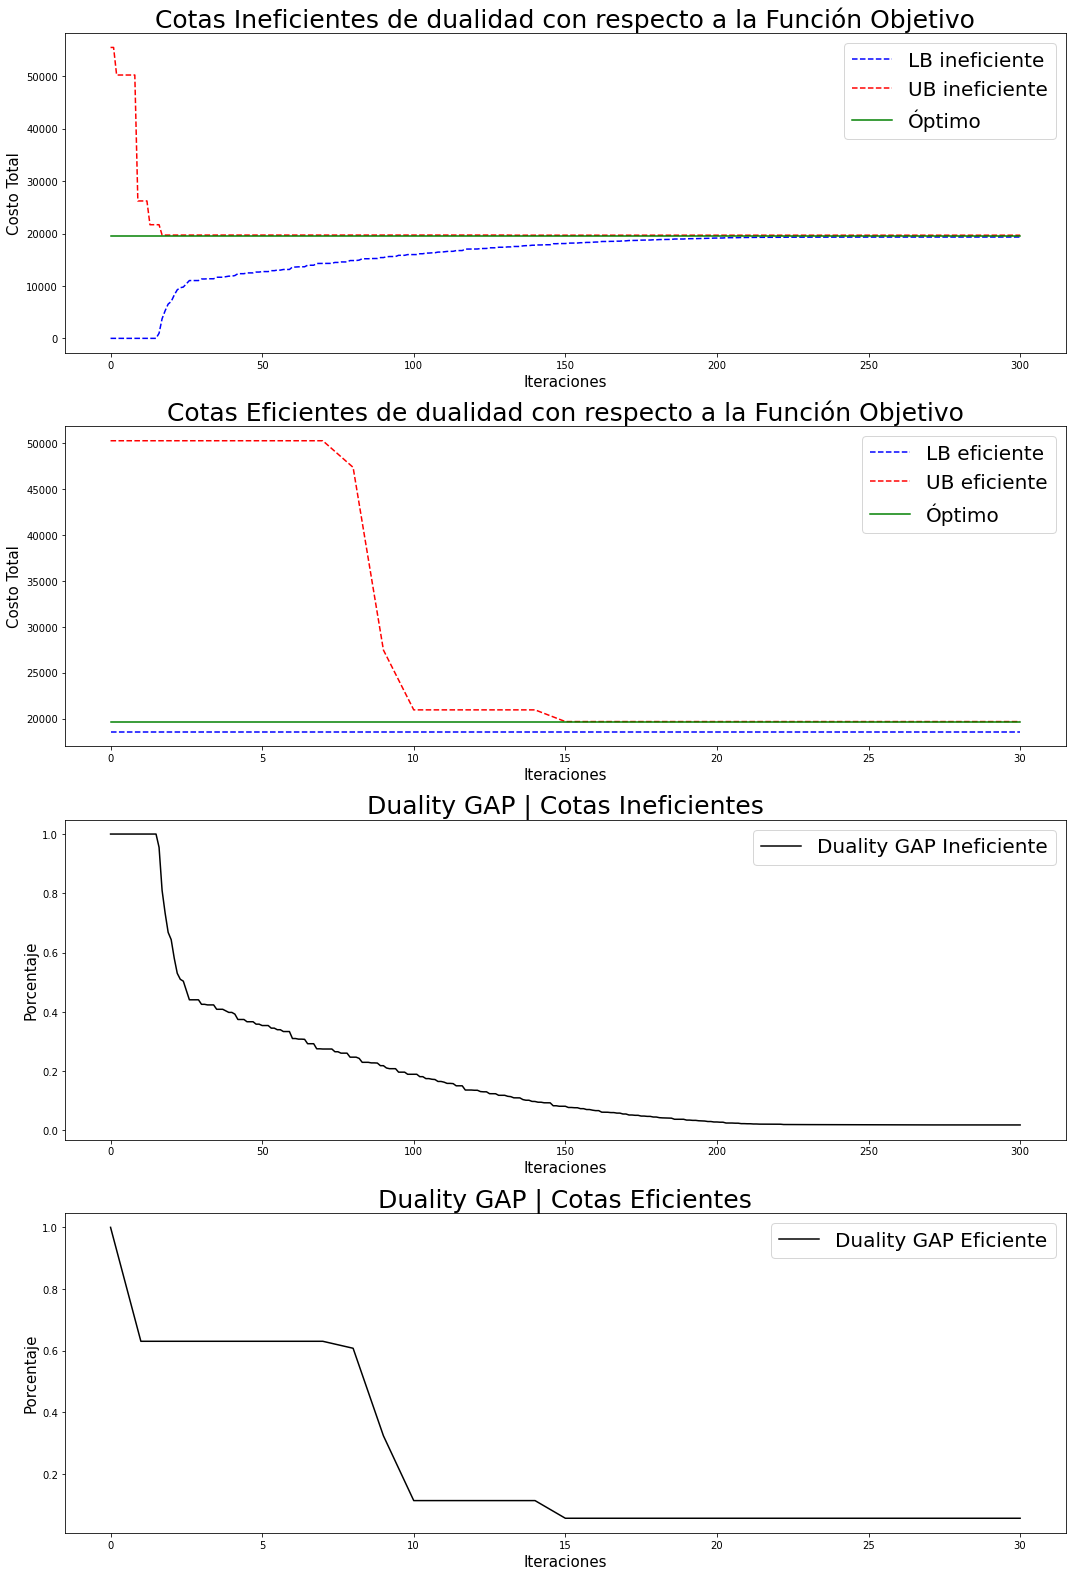

In [31]:
fig = plt.figure(figsize=(15,22))

ax = fig.add_subplot(411)
plt.title('Cotas Ineficientes de dualidad con respecto a la Función Objetivo',fontsize=25)
plt.xlabel("Iteraciones",fontsize=15)
plt.ylabel("Costo Total",fontsize=15)
plt.plot(LB2, "r--", label='LB ineficiente', color='b')
plt.plot(UB2, "r--", label='UB ineficiente', color='r')
plt.plot(óptimo2, label='Óptimo', color='g')
plt.legend(loc='best',prop = {'size' : 20})

ax = fig.add_subplot(412)
plt.title('Cotas Eficientes de dualidad con respecto a la Función Objetivo',fontsize=25)
plt.xlabel("Iteraciones",fontsize=15)
plt.ylabel("Costo Total",fontsize=15)
plt.plot(LB, "r--", label='LB eficiente', color='b')
plt.plot(UB, "r--", label='UB eficiente', color='r')
plt.plot(óptimo, label='Óptimo', color='g')
plt.legend(loc='best',prop = {'size' : 20})

ax = fig.add_subplot(413)
plt.title('Duality GAP | Cotas Ineficientes',fontsize=25)
plt.xlabel("Iteraciones",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)
plt.plot(GAP2, label='Duality GAP Ineficiente', color='black')
plt.legend(loc='best',prop = {'size' : 20})

ax = fig.add_subplot(414)
plt.title('Duality GAP | Cotas Eficientes',fontsize=25)
plt.xlabel("Iteraciones",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)
plt.plot(GAP, label='Duality GAP Eficiente', color='black')
plt.legend(loc='best',prop = {'size' : 20})

plt.tight_layout()

## <font color=#F03415> Tablas con resultados </font> 

### <font color=#F03415> Cotas iniciales vs solución óptima </font> 

In [32]:
# Se consideran las soluciones iniciales de las cotas eficientes e ineficientes, los cuales se comparan mediante el 
# resultado de las funciones objetivos y el GAP de estos frente al óptimo del problema CFCFLP.
nuevo_df=pd.DataFrame(resultados2,columns=['Modelo','Función Objetivo','GAP (%)'])
nuevo_df.set_index('Modelo',inplace=True)
nuevo_df

,Función Objetivo,GAP (%)
Modelo,,
Óptimo,19593.544157,0.0%
LB ineficientes iniciales,0.000000,100.0%
UB ineficientes iniciales,55500.119427,183.257%
LB eficientes iniciales,18578.829845,5.179%
UB eficientes iniciales,50239.154863,156.407%


### <font color=#F03415> Mejores soluciones de las cotas vs solución óptima </font> 

In [33]:
# Se consideran las mejores soluciones (máximo de la lista LB y mínimo de la lista de UB) de las cotas, para comparar
# los tiempos computacionales y el GAP. Cabe destacar que se consideran el mismo tiempo de los UB y LB dependiendo
# si son eficientes o ineficientes, es decir, el tiempo de ejecución de encontrar la mejor solución al problema. 

nuevo_df2=pd.DataFrame(resultados,columns=['Modelo','Función Objetivo','Tiempo computacional (segundos)','GAP (%)'])
nuevo_df2.set_index('Modelo',inplace=True)
nuevo_df2

,Función Objetivo,Tiempo computacional (segundos),GAP (%)
Modelo,,,
Óptimo,19593.544157,1.516210,0.0%
LB ineficientes,19329.732633,99.254255,1.346%
UB ineficientes,19677.443451,99.254255,0.428%
LB eficientes,19329.732633,6.856857,5.179%
UB eficientes,19677.443451,6.856857,0.428%


## <font color=#F03415> Conclusiones </font> 

- Al revisar los resultados de las iteraciones de los subproblemas eficientes e ineficientes, se puede visualizar que los multiplicadores de Lagrange ($\lambda _i$) y las cotas superiores son bastantes altos para ambos casos. Sin embargo, se puede evidenciar que utlizar cotas eficientes, permite reducir el espacio de soluciones factibles y se acercan rápidamente hacia el óptimo global.

- El Duality GAP de las cotas eficientes tiende a acercarse rápidamente al óptimo, sin embargo, su valor de 5,58%  es constante desde la iteración 15 debido a los parámetros establecidos en el problema planteado. Por el contrario, las cotas ineficientes alcanzan el duality GAP de 5,77% en la iteración 168 y 5,47% en la iteración 169. 

- El GAP de 5,179% del LB de las cotas eficientes, no sale del óptimo local de la solución óptima del problema CFCFLP relajado, mientras que las cotas ineficientes que inician con un LB=0, llegan a disminuir el GAP de la cota inferior a 1,346% en la iteración 300, la cual podría seguir disminuyendo con una mayor cantidad de iteraciones. Cabe destacar que el GAP de 0,428% del UB se alcanza en la iteración 15 con las cotas eficientes, mientras que el mismo GAP en las cotas ineficientes se alcanza en la iteración 132.

- El tiempo computacional al utilizar las cotas eficientes, no debiese superar los 3-4 segundos con los parámetros planteados, ya que el duality GAP de 5,58% se mantiene desde la mitad de las iteraciones realizadas. Además, este podría reducirse aún más, dado que el tiempo computacional considera los resultados impresos para evaluar las soluciones.

- En este ejemplo práctico, las cotas mejoran pero no convergen a un Duality GAP de 0,0%, por lo que no se encuentra el óptimo global. Sin embargo, al realizar un análisis de sensibilidad cambiando los valores de la escala, epsilón y límite del contador de iteraciones en que la cota inferior no haya cambiado, se puede encontrar la solución óptima. Cabe destacar que también se modificó la semilla a utilizar, la cantidad de iteraciones de los subproblemas y se ejecutaron los modelos con hasta 40 plantas y 40 clientes. 